# Imports

In [56]:
import pandas as pd
import seaborn as sns
import sklearn as sk
import datetime as dt
import numpy as np

# To ignore annoying warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Data Processing

## Selection of features

In [57]:
#Selection of existing relevant features per game : events that happened during each game
relevant_features = ['Date','HomeTeam','AwayTeam','IWH','IWD','IWA','FTR','FTHG','FTAG','HTHG','HTAG','HS','AS',
                     'HST','AST','HF','AF','HY','AY','HR','AR','HC','AC']

## Function for data processing of each season : creation of relevant features

In [97]:
def create_stat_dico(season: str, league: str) -> pd.DataFrame:
    
    """Compute statistics for a given season all the relevant statistics by going through each game
    
    Output a Dataframe of each game and each team statistics before the game
    
    Arguments : name of the season as a string, name of the league as a string
    """
    
    #stat_seasons is a 3-layer nested dico :
    # stats_season ---> dico of all clubs
    # club ---> dico of all week results
    # week ---> all stats for that week
    # stat ---> value for that specific game
     
    stats_season = {}
    file_name = '/Users/theophanegregoir/Desktop/BettingAI/Football_Data/Entire_Data_' + league + '.xlsx'
    xls_file = pd.ExcelFile(file_name)
    table = xls_file.parse(season)[relevant_features].dropna(axis=0)
    
    ###Features that describe team before the game
    table['week'] = 0
    
    ###For Home Team (HT)
    table['HT_average_points'] = 0.0
    table['HT_average_goal_scored_half_1'] = 0.0
    table['HT_average_goal_conceeded_half_1'] = 0.0
    table['HT_average_goal_scored_half_2'] = 0.0
    table['HT_average_goal_conceeded_half_2'] = 0.0
    table['HT_average_yellow'] = 0.0
    table['HT_average_red'] = 0.0
    table['HT_average_shots_per_goal'] = 0.0
    table['HT_on_target_precision'] = 0.0
    table['HT_average_shots_conceeded'] = 0.0
    table['HT_average_fouls_committed'] = 0.0
    table['HT_average_fouls_conceeded'] = 0.0
    
    ###For Away Team (AT)
    table['AT_average_points'] = 0.0
    table['AT_average_goal_scored_half_1'] = 0.0
    table['AT_average_goal_conceeded_half_1'] = 0.0
    table['AT_average_goal_scored_half_2'] = 0.0
    table['AT_average_goal_conceeded_half_2'] = 0.0
    table['AT_average_yellow'] = 0.0
    table['AT_average_red'] = 0.0
    table['AT_average_shots_per_goal'] = 0.0
    table['AT_on_target_precision'] = 0.0
    table['AT_average_shots_conceeded'] = 0.0
    table['AT_average_fouls_committed'] = 0.0
    table['AT_average_fouls_conceeded'] = 0.0
    
    #Number of weeks available
    nb_weeks = int(len(table)/10)
    
    if season == '2019-2020':
        nb_weeks = int(len(table)/10) - 1
    
    #Getting unique list of club names for this season
    clubs = list(set(list(table['HomeTeam'])))

    #Creation of the dictionary of stats for each club       
    for c in clubs:
        
        #First layer of dict
        stats_season[c] = {}
        
        #Selection of the games where the club is involved
        isHome = table['HomeTeam'] == c
        isAway = table['AwayTeam'] == c
        selected = table.loc[isHome | isAway]
        stats_season[c]['games_index'] = list(selected.index)
        
        
        #Initialisation of week 0 for additive params
        stats_season[c][0] = {}
        stats_season[c][0]['league_points'] = 0.0
        stats_season[c][0]['goals_scored'] = 0.0
        stats_season[c][0]['goals_scored_half'] = 0.0
        stats_season[c][0]['goals_conceeded'] = 0.0
        stats_season[c][0]['goals_conceeded_half'] = 0.0
        stats_season[c][0]['yellow'] = 0.0
        stats_season[c][0]['red'] = 0.0
        stats_season[c][0]['fouls_conceeded'] = 0.0
        stats_season[c][0]['fouls_committed'] = 0.0
        stats_season[c][0]['shots'] = 0.0
        stats_season[c][0]['shots_on_target'] = 0.0
        stats_season[c][0]['shots_conceeded'] = 0.0
        
        #Going through all the weeks of the season
        for k in range(1,len(selected)):
            
            #Second layer of dict
            stats_season[c][k] = {}
            
            #Third layer of dict
            if selected['AwayTeam'][selected.index[k-1]] == c :
                stats_season[c][k]['is_Home'] = False
            else :
                stats_season[c][k]['is_Home'] = True
            
            #Modifying the dataframe to add the statistics before game (based on previous weeks) use as features for ML
            if stats_season[c][k]['is_Home']:
                table.at[selected.index[k-1],'week'] = k
                table.at[selected.index[k-1],'HT_average_points'] = stats_season[c][k-1]['league_points'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_scored_half_2'] = (stats_season[c][k-1]['goals_scored'] - stats_season[c][k-1]['goals_scored_half'])/ max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_conceeded_half_2'] = (stats_season[c][k-1]['goals_conceeded'] - stats_season[c][k-1]['goals_conceeded_half'])/ max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_scored_half_1'] = stats_season[c][k-1]['goals_scored_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_conceeded_half_1'] =  stats_season[c][k-1]['goals_conceeded_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_shots_per_goal'] = sum([stats_season[c][j]['shots'] for j in range(k)]) / max(1.0,sum([stats_season[c][i]['goals_scored'] for i in range(k)]))
                table.at[selected.index[k-1],'HT_on_target_precision'] = sum([stats_season[c][j]['shots_on_target'] for j in range(k)]) / max(1.0,sum([stats_season[c][i]['shots'] for i in range(k)]))
                table.at[selected.index[k-1],'HT_average_shots_conceeded']= stats_season[c][k-1]['shots_conceeded'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_yellow'] = stats_season[c][k-1]['yellow'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_red'] = stats_season[c][k-1]['red'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_fouls_committed'] = stats_season[c][k-1]['fouls_committed'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] / max(k-1.0,1.0)
            else :
                table.at[selected.index[k-1],'AT_average_points'] = stats_season[c][k-1]['league_points'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_scored_half_2'] = (stats_season[c][k-1]['goals_scored'] - stats_season[c][k-1]['goals_scored_half'])/ max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_conceeded_half_2'] = (stats_season[c][k-1]['goals_conceeded'] - stats_season[c][k-1]['goals_conceeded_half'])/ max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_scored_half_1'] = stats_season[c][k-1]['goals_scored_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_conceeded_half_1'] =  stats_season[c][k-1]['goals_conceeded_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_shots_per_goal'] = sum([stats_season[c][j]['shots'] for j in range(k)]) / max(1.0,sum([stats_season[c][i]['goals_scored'] for i in range(k)]))
                table.at[selected.index[k-1],'AT_on_target_precision'] = sum([stats_season[c][j]['shots_on_target'] for j in range(k)]) / max(1.0,sum([stats_season[c][i]['shots'] for i in range(k)]))
                table.at[selected.index[k-1],'AT_average_shots_conceeded']= stats_season[c][k-1]['shots_conceeded'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_yellow'] = stats_season[c][k-1]['yellow'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_red'] = stats_season[c][k-1]['red'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_fouls_committed'] = stats_season[c][k-1]['fouls_committed'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] / max(k-1.0,1.0)
                
            #Gathering the statistics of the game for the club for next games
            #League points
            if selected['FTR'][selected.index[k-1]] == "D" :
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points'] + 1.0
            elif selected['FTR'][selected.index[k-1]] == "A" and selected['AwayTeam'][selected.index[k-1]] == c:
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points'] + 3.0
            elif selected['FTR'][selected.index[k-1]] == "H" and selected['HomeTeam'][selected.index[k-1]] == c:
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points'] + 3.0
            else:
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points']
            
            #Goals and shots
            if stats_season[c][k]['is_Home']:
                stats_season[c][k]['goals_scored'] = stats_season[c][k-1]['goals_scored'] + selected['FTHG'][selected.index[k-1]]
                stats_season[c][k]['goals_scored_half'] = stats_season[c][k-1]['goals_scored_half'] + selected['HTHG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded'] = stats_season[c][k-1]['goals_conceeded'] + selected['FTAG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded_half'] = stats_season[c][k-1]['goals_conceeded_half'] + selected['HTAG'][selected.index[k-1]]
                stats_season[c][k]['shots'] = stats_season[c][k-1]['shots'] + selected['HS'][selected.index[k-1]]
                stats_season[c][k]['shots_on_target'] = stats_season[c][k-1]['shots_on_target'] + selected['HST'][selected.index[k-1]]
                stats_season[c][k]['shots_conceeded'] = stats_season[c][k-1]['shots_conceeded'] + selected['AS'][selected.index[k-1]]
            else :
                stats_season[c][k]['goals_scored'] = stats_season[c][k-1]['goals_scored'] + selected['FTAG'][selected.index[k-1]]
                stats_season[c][k]['goals_scored_half'] = stats_season[c][k-1]['goals_scored_half'] + selected['HTAG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded'] = stats_season[c][k-1]['goals_conceeded'] + selected['FTHG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded_half'] = stats_season[c][k-1]['goals_conceeded_half'] + selected['HTHG'][selected.index[k-1]]
                stats_season[c][k]['shots'] = stats_season[c][k-1]['shots'] + selected['AS'][selected.index[k-1]]
                stats_season[c][k]['shots_on_target'] = stats_season[c][k-1]['shots_on_target'] + selected['AST'][selected.index[k-1]]
                stats_season[c][k]['shots_conceeded'] = stats_season[c][k-1]['shots_conceeded'] + selected['HS'][selected.index[k-1]]
            
            #Fouls and cards
            if stats_season[c][k]['is_Home']:
                stats_season[c][k]['yellow'] = stats_season[c][k-1]['yellow'] + selected['HY'][selected.index[k-1]]
                stats_season[c][k]['red'] = stats_season[c][k-1]['red'] + selected['HR'][selected.index[k-1]]
                stats_season[c][k]['fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] + selected['AF'][selected.index[k-1]]
                stats_season[c][k]['fouls_committed'] = stats_season[c][k-1]['fouls_committed'] + selected['HF'][selected.index[k-1]]
            else:
                stats_season[c][k]['yellow'] = stats_season[c][k-1]['yellow'] + selected['AY'][selected.index[k-1]]
                stats_season[c][k]['red'] = stats_season[c][k-1]['red'] + selected['AR'][selected.index[k-1]]
                stats_season[c][k]['fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] + selected['HF'][selected.index[k-1]]
                stats_season[c][k]['fouls_committed'] = stats_season[c][k-1]['fouls_committed'] + selected['AF'][selected.index[k-1]]
  
    return(table)

## Processing selected data

In [108]:
#List of all features created after processing
processed_features = ['week', 'HT_average_points', 'HT_average_goal_scored_half_1',
           'HT_average_goal_conceeded_half_1', 'HT_average_goal_scored_half_2',
           'HT_average_goal_conceeded_half_2', 'HT_average_yellow', 'HT_average_red',
           'HT_average_shots_per_goal', 'HT_on_target_precision',
           'HT_average_shots_conceeded', 'HT_average_fouls_committed',
           'HT_average_fouls_conceeded', 
           'AT_average_points', 'AT_average_goal_scored_half_1',
           'AT_average_goal_conceeded_half_1', 'AT_average_goal_scored_half_2',
           'AT_average_goal_conceeded_half_2', 'AT_average_yellow', 'AT_average_red',
           'AT_average_shots_per_goal', 'AT_on_target_precision',
           'AT_average_shots_conceeded', 'AT_average_fouls_committed',
           'AT_average_fouls_conceeded', 'FTR','IWH','IWD','IWA']

#Leagues selected
chosen_leagues = ['Ligue1','LaLiga','SerieA','Bundesliga','PL']

#Seasons selected
start_year = 2007
end_year = 2020

data_seasons = {}

for i in range(start_year,end_year):
    
    season = str(i) + '-' + str(i + 1)
    
    data_seasons[season] = {}
    
    for league in chosen_leagues:
        
        print("Processing " + league + ' ' + str(i) + '-' + str(i+1))

        table = create_stat_dico(season, league)

        full_table_add = table[processed_features]
 
        data_seasons[season][league] = full_table_add


Processing Ligue1 2007-2008
Processing LaLiga 2007-2008
Processing SerieA 2007-2008
Processing Bundesliga 2007-2008
Processing PL 2007-2008
Processing Ligue1 2008-2009
Processing LaLiga 2008-2009
Processing SerieA 2008-2009
Processing Bundesliga 2008-2009
Processing PL 2008-2009
Processing Ligue1 2009-2010
Processing LaLiga 2009-2010
Processing SerieA 2009-2010
Processing Bundesliga 2009-2010
Processing PL 2009-2010
Processing Ligue1 2010-2011
Processing LaLiga 2010-2011
Processing SerieA 2010-2011
Processing Bundesliga 2010-2011
Processing PL 2010-2011
Processing Ligue1 2011-2012
Processing LaLiga 2011-2012
Processing SerieA 2011-2012
Processing Bundesliga 2011-2012
Processing PL 2011-2012
Processing Ligue1 2012-2013
Processing LaLiga 2012-2013
Processing SerieA 2012-2013
Processing Bundesliga 2012-2013
Processing PL 2012-2013
Processing Ligue1 2013-2014
Processing LaLiga 2013-2014
Processing SerieA 2013-2014
Processing Bundesliga 2013-2014
Processing PL 2013-2014
Processing Ligue1 20

## Visualize data final format

In [109]:
#Visualize the format of dataframe
full_table_add

,week,HT_average_points,HT_average_goal_scored_half_1,HT_average_goal_conceeded_half_1,HT_average_goal_scored_half_2,HT_average_goal_conceeded_half_2,HT_average_yellow,HT_average_red,HT_average_shots_per_goal,HT_on_target_precision,...,AT_average_red,AT_average_shots_per_goal,AT_on_target_precision,AT_average_shots_conceeded,AT_average_fouls_committed,AT_average_fouls_conceeded,FTR,IWH,IWD,IWA
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,H,1.15,8.00,18.00
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,11.00,6.10,1.25
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,D,1.97,3.55,3.80
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,H,2.65,3.20,2.75
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,D,3.10,3.20,2.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,9.60,5.50,1.30
256,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,3.95,3.80,1.87
257,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,H,1.45,4.50,7.00
258,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,1.85,3.60,4.30


# Defining train and test datasets

## Training dataset

In [132]:
#Selection of seasons used to train
train_start_year = 2007
train_end_year = 2017

train_chosen_leagues = ['Ligue1','LaLiga','SerieA','Bundesliga','PL']

train_df = pd.DataFrame(columns = processed_features)

for i in range(train_start_year,train_end_year):
    
    season = str(i) + '-' + str(i + 1)
    
    for league in train_chosen_leagues:
        
        table = data_seasons[season][league]
        
        two_concat = [train_df, table]
        
        train_df = pd.concat(two_concat)
       

#Starting week of training
start_week_train = 20
valid = train_df['week'] > start_week_train
train_df = train_df[valid]
        
print("The model will train on : " + str(train_chosen_leagues))
        
print("The model will train on " + str(len(train_df)) + " matches from " + str(train_start_year) + '-' + str(train_start_year+1) + " to " + str(train_end_year-1) + '-' + str(train_end_year) + " !")

#Choice of the features
features = ['HT_average_goal_scored_half_1',
           'HT_average_goal_conceeded_half_1', 'HT_average_goal_scored_half_2',
           'HT_average_goal_conceeded_half_2',
           'HT_average_shots_per_goal', 'HT_on_target_precision',
           'HT_average_shots_conceeded',
           'AT_average_goal_scored_half_1',
           'AT_average_goal_conceeded_half_1', 'AT_average_goal_scored_half_2',
           'AT_average_goal_conceeded_half_2',
           'AT_average_shots_per_goal', 'AT_on_target_precision',
           'AT_average_shots_conceeded']

n_features = len(features)

train_x = train_df[features]

train_y = train_df['FTR']


The model will train on : ['Ligue1', 'LaLiga', 'SerieA', 'Bundesliga', 'PL']
The model will train on 7917 matches from 2007-2008 to 2016-2017 !


## Testing dataset

In [133]:
#Selection of seasons used to test
test_start_year = train_end_year
test_end_year = 2020

test_df = pd.DataFrame(columns = processed_features)

test_chosen_leagues = ['Ligue1','LaLiga','SerieA','Bundesliga','PL']

for i in range(test_start_year, test_end_year):
    
    season = str(i) + '-' + str(i + 1)
    
    for league in test_chosen_leagues:
        
        table = data_seasons[season][league]
        
        two_concat = [test_df, table]
        
        test_df = pd.concat(two_concat)

#Starting week of training
start_week_test = 20
valid = test_df['week'] > start_week_test
test_df = test_df[valid]

#Choice of the features (we first delete the odds)
test_x = test_df[features]

#Labels for training
test_y = test_df['FTR']


print("The model will test on : " + str(test_chosen_leagues))
      
print("The model will test on " + str(len(test_df)) + " matches from " + str(test_start_year) + '-' + str(test_start_year+1) + " to " + str(test_end_year-1) + '-' + str(test_end_year) + " !")



The model will test on : ['Ligue1', 'LaLiga', 'SerieA', 'Bundesliga', 'PL']
The model will test on 1833 matches from 2017-2018 to 2019-2020 !


# Let's apply classical ML algorithms

## Importing models

In [134]:
#Dealing with format and metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

#Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

#Classical classifiers
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

#Ensemblist models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

#Neural Networks
from sklearn.neural_network import MLPClassifier

## Training and testing : getting probabilities for test data

### GridSearch on Random Forest

In [135]:
parameters = {'n_estimators':[1000,2000], 'max_depth':[25,100], 'min_samples_split':[2,5,10]}

forest = RandomForestClassifier(criterion='gini', min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, max_features='auto', 
                                max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                min_impurity_split=None, bootstrap=True, oob_score=False, 
                                n_jobs=None, random_state=None)

RFClassifier = GridSearchCV(forest, parameters,verbose=100)

name = 'RF'

print("Training " + name + " ...")
RFClassifier.fit(train_x, train_y)

y_pred = RFClassifier.predict(test_x)
accuracy = accuracy_score(test_y, y_pred)
print("Accuracy (test) for %s: %0.1f%% " % (name, accuracy * 100))
    
#Calculate probabilities:
probas = RFClassifier.predict_proba(test_x)

Training RF ...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=25, min_samples_split=2, n_estimators=1000 ............
[CV]  max_depth=25, min_samples_split=2, n_estimators=1000, score=0.505, total=  12.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s
[CV] max_depth=25, min_samples_split=2, n_estimators=1000 ............
[CV]  max_depth=25, min_samples_split=2, n_estimators=1000, score=0.515, total=  11.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.7s remaining:    0.0s
[CV] max_depth=25, min_samples_split=2, n_estimators=1000 ............
[CV]  max_depth=25, min_samples_split=2, n_estimators=1000, score=0.532, total=  11.9s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   35.6s remaining:    0.0s
[CV] max_depth=25, min_samples_split=2, n_estimators=2000 ............
[CV]  max_depth=25, min_samples_split=2, n_estimators=200

### Testing various models

In [107]:
# Dealing with parameters
C = 0.8

# Create different classifiers.
classifiers = {
    'L1 logistic': LogisticRegression(C=C, penalty='l1',
                                      solver='saga', tol=0.000001,
                                      multi_class='multinomial',
                                      max_iter=1000000),
    'L2 logistic (Multinomial)': LogisticRegression(C=C, penalty='l2',
                                                    solver='saga', tol=0.000001,
                                                    multi_class='multinomial',
                                                    max_iter=1000000),
    'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2',
                                            solver='saga',
                                            multi_class='ovr',
                                            max_iter=10000),
    'Random Forest': RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=25, 
                                            min_samples_split=2, min_samples_leaf=1, 
                                            min_weight_fraction_leaf=0.0, max_features='auto', 
                                            max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                            min_impurity_split=None, bootstrap=True, oob_score=False, 
                                            n_jobs=None, random_state=None)
}

n_classifiers = len(classifiers)

results = {}

for index, (name, classifier) in enumerate(classifiers.items()):
    print("Training " + name + "...")
    classifier.fit(train_x, train_y)

    y_pred = classifier.predict(test_x)
    accuracy = accuracy_score(test_y, y_pred)
    print("Accuracy (test) for %s: %0.1f%% " % (name, accuracy * 100))
    
    #Calculate probabilities:
    probas = classifier.predict_proba(test_x)
    
    #store them in a dict
    results[name] = probas


Training L1 logistic...
Accuracy (test) for L1 logistic: 55.0% 
Training L2 logistic (Multinomial)...
Accuracy (test) for L2 logistic (Multinomial): 54.8% 
Training L2 logistic (OvR)...
Accuracy (test) for L2 logistic (OvR): 54.9% 
Training Random Forest...
Accuracy (test) for Random Forest: 67.3% 


# Let's try with Neural Networks

## Imports

In [118]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

#Keras tuners
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

#Time
import time

## Parameters

In [119]:
n_classes = 3
n_features = train_x.shape[1]
n_epochs = 10

## Preprocessing

In [136]:
test_X = test_x.values
test_Y = test_y.values
train_X = train_x.values
train_Y = train_y.values

#Features
min_max_scaler = preprocessing.MinMaxScaler()
train_X_scaled = min_max_scaler.fit_transform(train_X)
test_X_scaled = min_max_scaler.transform(test_X)

#Labels
# integer encode
label_encoder = LabelEncoder()
train_Y_integer_encoded = label_encoder.fit_transform(train_Y)
test_Y_integer_encoded = label_encoder.transform(test_Y)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
train_Y_integer_encoded = train_Y_integer_encoded.reshape(len(train_Y_integer_encoded), 1)
train_Y_onehot_encoded = onehot_encoder.fit_transform(train_Y_integer_encoded)
test_Y_integer_encoded = test_Y_integer_encoded.reshape(len(test_Y_integer_encoded), 1)
test_Y_onehot_encoded = onehot_encoder.transform(test_Y_integer_encoded)


## Searching for a relevant architecture model

In [124]:
log_dir = f"{int(time.time())}"

def build_model(hp):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(hp.Int("n_input_neurons",min_value = 10, max_value = 200, step = 20), input_dim=n_features, activation =tf.nn.relu))
    
    for i in range(hp.Int("n_layers", 1, 3)):
        model.add(tf.keras.layers.Dense(hp.Int(f"layer_{i}_neurons",min_value = 10, max_value = 200, step = 20), activation =tf.nn.relu))

    #Output layer
    model.add(tf.keras.layers.Dense(n_classes,activation =tf.nn.softmax))

    #Compile
    model.compile(optimizer = 'adam',
                  loss = 'categorical_crossentropy',
                  metrics = ["accuracy"])
    return model

tuner = RandomSearch(
        build_model,
        objective = "val_acc",
        max_trials = 10,
        executions_per_trial = 1,
        directory = log_dir
        )

tuner.search(x = train_X_scaled,
             y = train_Y_onehot_encoded,
             epochs = 10,
             batch_size = 25,
             validation_data = (test_X_scaled, test_Y_onehot_encoded))

Train on 7917 samples, validate on 1833 samples
Epoch 1/10
7917/7917 [==============================] - ETA: 1:51 - loss: 1.1589 - acc: 0.240 - ETA: 26s - loss: 1.1069 - acc: 0.304 - ETA: 16s - loss: 1.0891 - acc: 0.36 - ETA: 11s - loss: 1.0832 - acc: 0.42 - ETA: 7s - loss: 1.0926 - acc: 0.4296 - ETA: 5s - loss: 1.0859 - acc: 0.446 - ETA: 4s - loss: 1.0861 - acc: 0.449 - ETA: 3s - loss: 1.0769 - acc: 0.471 - ETA: 3s - loss: 1.0744 - acc: 0.475 - ETA: 2s - loss: 1.0756 - acc: 0.469 - ETA: 2s - loss: 1.0761 - acc: 0.467 - ETA: 2s - loss: 1.0733 - acc: 0.476 - ETA: 2s - loss: 1.0708 - acc: 0.480 - ETA: 2s - loss: 1.0699 - acc: 0.480 - ETA: 2s - loss: 1.0710 - acc: 0.480 - ETA: 1s - loss: 1.0709 - acc: 0.480 - ETA: 1s - loss: 1.0698 - acc: 0.481 - ETA: 1s - loss: 1.0657 - acc: 0.487 - ETA: 1s - loss: 1.0627 - acc: 0.489 - ETA: 1s - loss: 1.0637 - acc: 0.488 - ETA: 1s - loss: 1.0612 - acc: 0.489 - ETA: 1s - loss: 1.0616 - acc: 0.487 - ETA: 1s - loss: 1.0609 - acc: 0.487 - ETA: 0s - loss: 1.

7917/7917 [==============================] - ETA: 3s - loss: 1.0637 - acc: 0.320 - ETA: 2s - loss: 0.9905 - acc: 0.512 - ETA: 2s - loss: 0.9667 - acc: 0.550 - ETA: 2s - loss: 0.9729 - acc: 0.532 - ETA: 1s - loss: 0.9594 - acc: 0.545 - ETA: 1s - loss: 0.9706 - acc: 0.535 - ETA: 1s - loss: 0.9693 - acc: 0.544 - ETA: 1s - loss: 0.9713 - acc: 0.543 - ETA: 1s - loss: 0.9683 - acc: 0.542 - ETA: 1s - loss: 0.9669 - acc: 0.541 - ETA: 1s - loss: 0.9647 - acc: 0.541 - ETA: 1s - loss: 0.9664 - acc: 0.539 - ETA: 1s - loss: 0.9643 - acc: 0.538 - ETA: 1s - loss: 0.9644 - acc: 0.539 - ETA: 1s - loss: 0.9636 - acc: 0.540 - ETA: 1s - loss: 0.9651 - acc: 0.539 - ETA: 1s - loss: 0.9653 - acc: 0.541 - ETA: 1s - loss: 0.9671 - acc: 0.541 - ETA: 1s - loss: 0.9688 - acc: 0.539 - ETA: 1s - loss: 0.9689 - acc: 0.538 - ETA: 1s - loss: 0.9704 - acc: 0.534 - ETA: 1s - loss: 0.9691 - acc: 0.536 - ETA: 1s - loss: 0.9698 - acc: 0.534 - ETA: 0s - loss: 0.9738 - acc: 0.532 - ETA: 0s - loss: 0.9758 - acc: 0.529 - ETA: 

Train on 7917 samples, validate on 1833 samples
Epoch 1/10
7917/7917 [==============================] - ETA: 1:40 - loss: 1.0376 - acc: 0.640 - ETA: 9s - loss: 1.0602 - acc: 0.4900  - ETA: 5s - loss: 1.0611 - acc: 0.476 - ETA: 4s - loss: 1.0569 - acc: 0.473 - ETA: 3s - loss: 1.0528 - acc: 0.474 - ETA: 3s - loss: 1.0487 - acc: 0.471 - ETA: 2s - loss: 1.0462 - acc: 0.470 - ETA: 2s - loss: 1.0389 - acc: 0.477 - ETA: 2s - loss: 1.0321 - acc: 0.484 - ETA: 2s - loss: 1.0217 - acc: 0.494 - ETA: 1s - loss: 1.0198 - acc: 0.500 - ETA: 1s - loss: 1.0167 - acc: 0.502 - ETA: 1s - loss: 1.0179 - acc: 0.498 - ETA: 1s - loss: 1.0152 - acc: 0.498 - ETA: 1s - loss: 1.0131 - acc: 0.499 - ETA: 1s - loss: 1.0130 - acc: 0.498 - ETA: 1s - loss: 1.0093 - acc: 0.502 - ETA: 1s - loss: 1.0106 - acc: 0.501 - ETA: 1s - loss: 1.0147 - acc: 0.496 - ETA: 0s - loss: 1.0125 - acc: 0.497 - ETA: 0s - loss: 1.0123 - acc: 0.498 - ETA: 0s - loss: 1.0092 - acc: 0.500 - ETA: 0s - loss: 1.0066 - acc: 0.503 - ETA: 0s - loss: 1.

Train on 7917 samples, validate on 1833 samples
Epoch 1/10
7917/7917 [==============================] - ETA: 2:36 - loss: 1.0387 - acc: 0.600 - ETA: 11s - loss: 1.0834 - acc: 0.429 - ETA: 5s - loss: 1.0626 - acc: 0.4386 - ETA: 4s - loss: 1.0440 - acc: 0.459 - ETA: 3s - loss: 1.0421 - acc: 0.461 - ETA: 2s - loss: 1.0422 - acc: 0.460 - ETA: 2s - loss: 1.0329 - acc: 0.470 - ETA: 1s - loss: 1.0337 - acc: 0.471 - ETA: 1s - loss: 1.0268 - acc: 0.476 - ETA: 1s - loss: 1.0260 - acc: 0.479 - ETA: 1s - loss: 1.0212 - acc: 0.483 - ETA: 1s - loss: 1.0159 - acc: 0.492 - ETA: 1s - loss: 1.0131 - acc: 0.494 - ETA: 0s - loss: 1.0129 - acc: 0.496 - ETA: 0s - loss: 1.0115 - acc: 0.499 - ETA: 0s - loss: 1.0109 - acc: 0.501 - ETA: 0s - loss: 1.0126 - acc: 0.498 - ETA: 0s - loss: 1.0118 - acc: 0.500 - ETA: 0s - loss: 1.0098 - acc: 0.501 - ETA: 0s - loss: 1.0104 - acc: 0.500 - ETA: 0s - loss: 1.0091 - acc: 0.501 - ETA: 0s - loss: 1.0105 - acc: 0.501 - ETA: 0s - loss: 1.0090 - acc: 0.502 - ETA: 0s - loss: 1.

Train on 7917 samples, validate on 1833 samples
Epoch 1/10
7917/7917 [==============================] - ETA: 2:18 - loss: 1.1016 - acc: 0.200 - ETA: 7s - loss: 1.0754 - acc: 0.4560  - ETA: 4s - loss: 1.0669 - acc: 0.460 - ETA: 3s - loss: 1.0612 - acc: 0.466 - ETA: 2s - loss: 1.0531 - acc: 0.471 - ETA: 1s - loss: 1.0516 - acc: 0.471 - ETA: 1s - loss: 1.0484 - acc: 0.471 - ETA: 1s - loss: 1.0428 - acc: 0.477 - ETA: 1s - loss: 1.0411 - acc: 0.477 - ETA: 0s - loss: 1.0367 - acc: 0.481 - ETA: 0s - loss: 1.0338 - acc: 0.482 - ETA: 0s - loss: 1.0308 - acc: 0.484 - ETA: 0s - loss: 1.0291 - acc: 0.486 - ETA: 0s - loss: 1.0249 - acc: 0.490 - ETA: 0s - loss: 1.0227 - acc: 0.493 - ETA: 0s - loss: 1.0221 - acc: 0.492 - ETA: 0s - loss: 1.0186 - acc: 0.496 - ETA: 0s - loss: 1.0193 - acc: 0.495 - ETA: 0s - loss: 1.0185 - acc: 0.495 - ETA: 0s - loss: 1.0174 - acc: 0.496 - 2s 236us/sample - loss: 1.0172 - acc: 0.4967 - val_loss: 0.9844 - val_acc: 0.5254
Epoch 2/10
7917/7917 [============================

Train on 7917 samples, validate on 1833 samples
Epoch 1/10
7917/7917 [==============================] - ETA: 1:55 - loss: 1.0864 - acc: 0.200 - ETA: 9s - loss: 1.0702 - acc: 0.4143  - ETA: 4s - loss: 1.0604 - acc: 0.437 - ETA: 3s - loss: 1.0462 - acc: 0.455 - ETA: 2s - loss: 1.0445 - acc: 0.457 - ETA: 2s - loss: 1.0329 - acc: 0.474 - ETA: 2s - loss: 1.0299 - acc: 0.482 - ETA: 1s - loss: 1.0231 - acc: 0.488 - ETA: 1s - loss: 1.0210 - acc: 0.488 - ETA: 1s - loss: 1.0186 - acc: 0.488 - ETA: 1s - loss: 1.0158 - acc: 0.493 - ETA: 1s - loss: 1.0138 - acc: 0.497 - ETA: 0s - loss: 1.0137 - acc: 0.498 - ETA: 0s - loss: 1.0096 - acc: 0.501 - ETA: 0s - loss: 1.0097 - acc: 0.501 - ETA: 0s - loss: 1.0087 - acc: 0.502 - ETA: 0s - loss: 1.0089 - acc: 0.504 - ETA: 0s - loss: 1.0075 - acc: 0.504 - ETA: 0s - loss: 1.0061 - acc: 0.505 - ETA: 0s - loss: 1.0067 - acc: 0.506 - ETA: 0s - loss: 1.0054 - acc: 0.507 - ETA: 0s - loss: 1.0058 - acc: 0.506 - ETA: 0s - loss: 1.0047 - acc: 0.507 - ETA: 0s - loss: 1.

Train on 7917 samples, validate on 1833 samples
Epoch 1/10
7917/7917 [==============================] - ETA: 3:16 - loss: 1.1229 - acc: 0.200 - ETA: 17s - loss: 1.0978 - acc: 0.333 - ETA: 9s - loss: 1.0908 - acc: 0.4417 - ETA: 6s - loss: 1.0827 - acc: 0.467 - ETA: 5s - loss: 1.0835 - acc: 0.477 - ETA: 4s - loss: 1.0810 - acc: 0.478 - ETA: 3s - loss: 1.0800 - acc: 0.475 - ETA: 3s - loss: 1.0783 - acc: 0.474 - ETA: 2s - loss: 1.0746 - acc: 0.474 - ETA: 2s - loss: 1.0746 - acc: 0.477 - ETA: 2s - loss: 1.0730 - acc: 0.480 - ETA: 1s - loss: 1.0709 - acc: 0.482 - ETA: 1s - loss: 1.0678 - acc: 0.487 - ETA: 1s - loss: 1.0654 - acc: 0.488 - ETA: 1s - loss: 1.0618 - acc: 0.491 - ETA: 1s - loss: 1.0618 - acc: 0.488 - ETA: 1s - loss: 1.0593 - acc: 0.490 - ETA: 1s - loss: 1.0568 - acc: 0.492 - ETA: 1s - loss: 1.0557 - acc: 0.492 - ETA: 0s - loss: 1.0526 - acc: 0.494 - ETA: 0s - loss: 1.0512 - acc: 0.493 - ETA: 0s - loss: 1.0508 - acc: 0.492 - ETA: 0s - loss: 1.0491 - acc: 0.493 - ETA: 0s - loss: 1.

Train on 7917 samples, validate on 1833 samples
Epoch 1/10
7917/7917 [==============================] - ETA: 2:38 - loss: 1.0811 - acc: 0.520 - ETA: 15s - loss: 1.0920 - acc: 0.432 - ETA: 8s - loss: 1.0949 - acc: 0.4127 - ETA: 5s - loss: 1.0830 - acc: 0.426 - ETA: 4s - loss: 1.0694 - acc: 0.443 - ETA: 3s - loss: 1.0616 - acc: 0.451 - ETA: 3s - loss: 1.0511 - acc: 0.470 - ETA: 2s - loss: 1.0433 - acc: 0.477 - ETA: 3s - loss: 1.0435 - acc: 0.477 - ETA: 3s - loss: 1.0449 - acc: 0.475 - ETA: 3s - loss: 1.0440 - acc: 0.475 - ETA: 3s - loss: 1.0440 - acc: 0.477 - ETA: 3s - loss: 1.0396 - acc: 0.480 - ETA: 3s - loss: 1.0414 - acc: 0.478 - ETA: 2s - loss: 1.0351 - acc: 0.485 - ETA: 2s - loss: 1.0310 - acc: 0.486 - ETA: 2s - loss: 1.0268 - acc: 0.490 - ETA: 2s - loss: 1.0228 - acc: 0.494 - ETA: 2s - loss: 1.0195 - acc: 0.497 - ETA: 1s - loss: 1.0175 - acc: 0.498 - ETA: 1s - loss: 1.0162 - acc: 0.500 - ETA: 1s - loss: 1.0141 - acc: 0.502 - ETA: 1s - loss: 1.0144 - acc: 0.501 - ETA: 1s - loss: 1.

Train on 7917 samples, validate on 1833 samples
Epoch 1/10
7917/7917 [==============================] - ETA: 2:19 - loss: 1.0990 - acc: 0.320 - ETA: 9s - loss: 1.0650 - acc: 0.4575  - ETA: 5s - loss: 1.0557 - acc: 0.458 - ETA: 3s - loss: 1.0546 - acc: 0.473 - ETA: 2s - loss: 1.0447 - acc: 0.473 - ETA: 2s - loss: 1.0417 - acc: 0.474 - ETA: 2s - loss: 1.0356 - acc: 0.480 - ETA: 1s - loss: 1.0301 - acc: 0.488 - ETA: 1s - loss: 1.0269 - acc: 0.494 - ETA: 1s - loss: 1.0196 - acc: 0.501 - ETA: 1s - loss: 1.0172 - acc: 0.502 - ETA: 1s - loss: 1.0161 - acc: 0.502 - ETA: 0s - loss: 1.0162 - acc: 0.502 - ETA: 0s - loss: 1.0115 - acc: 0.507 - ETA: 0s - loss: 1.0107 - acc: 0.508 - ETA: 0s - loss: 1.0097 - acc: 0.509 - ETA: 0s - loss: 1.0041 - acc: 0.515 - ETA: 0s - loss: 1.0034 - acc: 0.515 - ETA: 0s - loss: 1.0051 - acc: 0.511 - ETA: 0s - loss: 1.0056 - acc: 0.510 - ETA: 0s - loss: 1.0060 - acc: 0.508 - ETA: 0s - loss: 1.0051 - acc: 0.508 - ETA: 0s - loss: 1.0043 - acc: 0.510 - 2s 273us/sample - 

Train on 7917 samples, validate on 1833 samples
Epoch 1/10
7917/7917 [==============================] - ETA: 2:47 - loss: 1.1072 - acc: 0.200 - ETA: 12s - loss: 1.0768 - acc: 0.431 - ETA: 7s - loss: 1.0669 - acc: 0.4354 - ETA: 5s - loss: 1.0584 - acc: 0.458 - ETA: 4s - loss: 1.0561 - acc: 0.461 - ETA: 4s - loss: 1.0511 - acc: 0.467 - ETA: 4s - loss: 1.0512 - acc: 0.464 - ETA: 4s - loss: 1.0494 - acc: 0.466 - ETA: 4s - loss: 1.0478 - acc: 0.469 - ETA: 3s - loss: 1.0448 - acc: 0.473 - ETA: 3s - loss: 1.0415 - acc: 0.474 - ETA: 2s - loss: 1.0358 - acc: 0.481 - ETA: 2s - loss: 1.0355 - acc: 0.476 - ETA: 2s - loss: 1.0323 - acc: 0.480 - ETA: 1s - loss: 1.0285 - acc: 0.484 - ETA: 1s - loss: 1.0234 - acc: 0.489 - ETA: 1s - loss: 1.0215 - acc: 0.491 - ETA: 1s - loss: 1.0221 - acc: 0.491 - ETA: 1s - loss: 1.0209 - acc: 0.491 - ETA: 1s - loss: 1.0213 - acc: 0.490 - ETA: 0s - loss: 1.0167 - acc: 0.495 - ETA: 0s - loss: 1.0169 - acc: 0.495 - ETA: 0s - loss: 1.0148 - acc: 0.498 - ETA: 0s - loss: 1.

Train on 7917 samples, validate on 1833 samples
Epoch 1/10
7917/7917 [==============================] - ETA: 2:13 - loss: 1.1045 - acc: 0.360 - ETA: 11s - loss: 1.0804 - acc: 0.443 - ETA: 5s - loss: 1.0546 - acc: 0.4696 - ETA: 3s - loss: 1.0542 - acc: 0.464 - ETA: 3s - loss: 1.0454 - acc: 0.467 - ETA: 3s - loss: 1.0463 - acc: 0.467 - ETA: 3s - loss: 1.0464 - acc: 0.469 - ETA: 2s - loss: 1.0373 - acc: 0.481 - ETA: 2s - loss: 1.0306 - acc: 0.484 - ETA: 1s - loss: 1.0265 - acc: 0.483 - ETA: 1s - loss: 1.0269 - acc: 0.483 - ETA: 1s - loss: 1.0256 - acc: 0.485 - ETA: 1s - loss: 1.0193 - acc: 0.492 - ETA: 1s - loss: 1.0197 - acc: 0.492 - ETA: 0s - loss: 1.0171 - acc: 0.494 - ETA: 0s - loss: 1.0129 - acc: 0.498 - ETA: 0s - loss: 1.0135 - acc: 0.499 - ETA: 0s - loss: 1.0113 - acc: 0.500 - ETA: 0s - loss: 1.0111 - acc: 0.500 - ETA: 0s - loss: 1.0130 - acc: 0.499 - ETA: 0s - loss: 1.0126 - acc: 0.501 - ETA: 0s - loss: 1.0107 - acc: 0.502 - ETA: 0s - loss: 1.0104 - acc: 0.503 - ETA: 0s - loss: 1.

INFO:tensorflow:Oracle triggered exit


In [125]:
print("The best hyperparemeters found are : ")
print(tuner.get_best_hyperparameters()[0].values)
print("Now the results summary : ")
print(tuner.results_summary())
print("The summary for the best model : ")
print(tuner.get_best_models()[0].summary())

The best hyperparemeters found are : 
{'n_input_neurons': 70, 'n_layers': 3, 'layer_0_neurons': 110, 'layer_1_neurons': 50, 'layer_2_neurons': 110}
Now the results summary : 


None
The summary for the best model : 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 70)                1050      
_________________________________________________________________
dense_1 (Dense)              (None, 110)               7810      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5550      
_________________________________________________________________
dense_3 (Dense)              (None, 110)               5610      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 333       
Total params: 20,353
Trainable params: 20,353
Non-trainable params: 0
_________________________________________________________________
None


## Choosing final model

In [137]:
final_model = tf.keras.models.Sequential()
    
final_model.add(tf.keras.layers.Dense(100, input_dim=n_features, activation = tf.nn.relu))
final_model.add(tf.keras.layers.Dropout(0.2))

for i in range(2):
    final_model.add(tf.keras.layers.Dense(150, activation = tf.nn.relu))
    final_model.add(tf.keras.layers.Dropout(0.2))

final_model.add(tf.keras.layers.Dense(30, input_dim=n_features, activation = tf.nn.relu)) 
final_model.add(tf.keras.layers.Dropout(0.2))

#Output layer
final_model.add(tf.keras.layers.Dense(n_classes,activation = tf.nn.softmax))

#Compile
final_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ["accuracy"])

#Fit
final_model.fit(train_X_scaled, train_Y_onehot_encoded,
          batch_size=20,
          epochs=100,
          validation_data=(test_X_scaled, test_Y_onehot_encoded))

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = final_model.evaluate(test_X_scaled, test_Y_onehot_encoded, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = final_model.predict(test_X_scaled[:3])
print('predictions shape:', predictions.shape)


Train on 7917 samples, validate on 1833 samples
Epoch 1/100
7917/7917 [==============================] - ETA: 5:31 - loss: 1.0852 - acc: 0.450 - ETA: 57s - loss: 1.0750 - acc: 0.466 - ETA: 36s - loss: 1.0871 - acc: 0.41 - ETA: 25s - loss: 1.0682 - acc: 0.45 - ETA: 16s - loss: 1.0695 - acc: 0.45 - ETA: 12s - loss: 1.0686 - acc: 0.46 - ETA: 11s - loss: 1.0678 - acc: 0.46 - ETA: 9s - loss: 1.0659 - acc: 0.4686 - ETA: 8s - loss: 1.0672 - acc: 0.467 - ETA: 7s - loss: 1.0653 - acc: 0.472 - ETA: 7s - loss: 1.0699 - acc: 0.460 - ETA: 6s - loss: 1.0705 - acc: 0.465 - ETA: 6s - loss: 1.0716 - acc: 0.465 - ETA: 5s - loss: 1.0725 - acc: 0.465 - ETA: 5s - loss: 1.0730 - acc: 0.463 - ETA: 5s - loss: 1.0746 - acc: 0.459 - ETA: 4s - loss: 1.0737 - acc: 0.459 - ETA: 4s - loss: 1.0734 - acc: 0.457 - ETA: 4s - loss: 1.0737 - acc: 0.456 - ETA: 4s - loss: 1.0745 - acc: 0.454 - ETA: 3s - loss: 1.0742 - acc: 0.455 - ETA: 3s - loss: 1.0745 - acc: 0.457 - ETA: 3s - loss: 1.0744 - acc: 0.457 - ETA: 3s - loss: 1

Epoch 6/100
7917/7917 [==============================] - ETA: 6s - loss: 0.9713 - acc: 0.650 - ETA: 4s - loss: 1.0332 - acc: 0.558 - ETA: 3s - loss: 1.0358 - acc: 0.537 - ETA: 3s - loss: 1.0512 - acc: 0.515 - ETA: 3s - loss: 1.0586 - acc: 0.494 - ETA: 2s - loss: 1.0631 - acc: 0.485 - ETA: 2s - loss: 1.0649 - acc: 0.480 - ETA: 2s - loss: 1.0677 - acc: 0.476 - ETA: 2s - loss: 1.0675 - acc: 0.475 - ETA: 2s - loss: 1.0732 - acc: 0.462 - ETA: 2s - loss: 1.0720 - acc: 0.465 - ETA: 2s - loss: 1.0716 - acc: 0.465 - ETA: 2s - loss: 1.0725 - acc: 0.462 - ETA: 2s - loss: 1.0721 - acc: 0.461 - ETA: 2s - loss: 1.0694 - acc: 0.467 - ETA: 1s - loss: 1.0695 - acc: 0.466 - ETA: 1s - loss: 1.0688 - acc: 0.466 - ETA: 1s - loss: 1.0692 - acc: 0.466 - ETA: 1s - loss: 1.0694 - acc: 0.466 - ETA: 1s - loss: 1.0696 - acc: 0.465 - ETA: 1s - loss: 1.0697 - acc: 0.465 - ETA: 1s - loss: 1.0684 - acc: 0.468 - ETA: 1s - loss: 1.0693 - acc: 0.466 - ETA: 1s - loss: 1.0701 - acc: 0.464 - ETA: 1s - loss: 1.0704 - acc: 0

7917/7917 [==============================] - ETA: 7s - loss: 1.1337 - acc: 0.300 - ETA: 4s - loss: 1.0680 - acc: 0.450 - ETA: 4s - loss: 1.0374 - acc: 0.516 - ETA: 3s - loss: 1.0476 - acc: 0.502 - ETA: 3s - loss: 1.0445 - acc: 0.509 - ETA: 2s - loss: 1.0506 - acc: 0.495 - ETA: 2s - loss: 1.0546 - acc: 0.489 - ETA: 2s - loss: 1.0582 - acc: 0.479 - ETA: 2s - loss: 1.0613 - acc: 0.473 - ETA: 2s - loss: 1.0638 - acc: 0.472 - ETA: 2s - loss: 1.0666 - acc: 0.466 - ETA: 2s - loss: 1.0686 - acc: 0.461 - ETA: 2s - loss: 1.0692 - acc: 0.459 - ETA: 2s - loss: 1.0681 - acc: 0.462 - ETA: 2s - loss: 1.0674 - acc: 0.463 - ETA: 2s - loss: 1.0661 - acc: 0.468 - ETA: 2s - loss: 1.0657 - acc: 0.470 - ETA: 1s - loss: 1.0652 - acc: 0.472 - ETA: 1s - loss: 1.0680 - acc: 0.467 - ETA: 1s - loss: 1.0670 - acc: 0.469 - ETA: 1s - loss: 1.0649 - acc: 0.472 - ETA: 1s - loss: 1.0658 - acc: 0.470 - ETA: 1s - loss: 1.0658 - acc: 0.471 - ETA: 1s - loss: 1.0653 - acc: 0.472 - ETA: 1s - loss: 1.0650 - acc: 0.472 - ETA: 

7917/7917 [==============================] - ETA: 6s - loss: 1.0198 - acc: 0.550 - ETA: 3s - loss: 1.0784 - acc: 0.456 - ETA: 2s - loss: 1.0688 - acc: 0.453 - ETA: 2s - loss: 1.0681 - acc: 0.456 - ETA: 2s - loss: 1.0695 - acc: 0.456 - ETA: 2s - loss: 1.0680 - acc: 0.457 - ETA: 2s - loss: 1.0644 - acc: 0.469 - ETA: 2s - loss: 1.0616 - acc: 0.475 - ETA: 2s - loss: 1.0600 - acc: 0.479 - ETA: 2s - loss: 1.0602 - acc: 0.478 - ETA: 2s - loss: 1.0591 - acc: 0.479 - ETA: 2s - loss: 1.0614 - acc: 0.472 - ETA: 2s - loss: 1.0608 - acc: 0.473 - ETA: 2s - loss: 1.0620 - acc: 0.469 - ETA: 1s - loss: 1.0600 - acc: 0.473 - ETA: 1s - loss: 1.0615 - acc: 0.470 - ETA: 1s - loss: 1.0606 - acc: 0.473 - ETA: 1s - loss: 1.0598 - acc: 0.474 - ETA: 1s - loss: 1.0592 - acc: 0.474 - ETA: 1s - loss: 1.0587 - acc: 0.475 - ETA: 1s - loss: 1.0587 - acc: 0.475 - ETA: 1s - loss: 1.0598 - acc: 0.474 - ETA: 1s - loss: 1.0617 - acc: 0.470 - ETA: 1s - loss: 1.0611 - acc: 0.471 - ETA: 1s - loss: 1.0617 - acc: 0.471 - ETA: 

7917/7917 [==============================] - ETA: 8s - loss: 1.0971 - acc: 0.400 - ETA: 11s - loss: 1.0833 - acc: 0.43 - ETA: 8s - loss: 1.0771 - acc: 0.4500 - ETA: 7s - loss: 1.0846 - acc: 0.430 - ETA: 7s - loss: 1.0865 - acc: 0.434 - ETA: 5s - loss: 1.0720 - acc: 0.452 - ETA: 5s - loss: 1.0667 - acc: 0.457 - ETA: 5s - loss: 1.0704 - acc: 0.455 - ETA: 5s - loss: 1.0724 - acc: 0.453 - ETA: 6s - loss: 1.0728 - acc: 0.451 - ETA: 6s - loss: 1.0738 - acc: 0.450 - ETA: 6s - loss: 1.0712 - acc: 0.454 - ETA: 7s - loss: 1.0708 - acc: 0.455 - ETA: 8s - loss: 1.0732 - acc: 0.450 - ETA: 9s - loss: 1.0709 - acc: 0.455 - ETA: 9s - loss: 1.0732 - acc: 0.451 - ETA: 9s - loss: 1.0734 - acc: 0.450 - ETA: 10s - loss: 1.0728 - acc: 0.45 - ETA: 11s - loss: 1.0723 - acc: 0.45 - ETA: 11s - loss: 1.0740 - acc: 0.45 - ETA: 11s - loss: 1.0738 - acc: 0.44 - ETA: 12s - loss: 1.0739 - acc: 0.45 - ETA: 12s - loss: 1.0751 - acc: 0.44 - ETA: 12s - loss: 1.0750 - acc: 0.44 - ETA: 11s - loss: 1.0692 - acc: 0.45 - ETA:

7917/7917 [==============================] - ETA: 13s - loss: 1.0009 - acc: 0.55 - ETA: 5s - loss: 1.0729 - acc: 0.4417 - ETA: 6s - loss: 1.0464 - acc: 0.488 - ETA: 5s - loss: 1.0580 - acc: 0.460 - ETA: 5s - loss: 1.0478 - acc: 0.478 - ETA: 5s - loss: 1.0552 - acc: 0.466 - ETA: 5s - loss: 1.0489 - acc: 0.486 - ETA: 5s - loss: 1.0500 - acc: 0.482 - ETA: 5s - loss: 1.0459 - acc: 0.494 - ETA: 6s - loss: 1.0476 - acc: 0.491 - ETA: 6s - loss: 1.0508 - acc: 0.483 - ETA: 6s - loss: 1.0532 - acc: 0.482 - ETA: 6s - loss: 1.0554 - acc: 0.478 - ETA: 6s - loss: 1.0585 - acc: 0.471 - ETA: 6s - loss: 1.0588 - acc: 0.469 - ETA: 6s - loss: 1.0638 - acc: 0.461 - ETA: 6s - loss: 1.0619 - acc: 0.464 - ETA: 6s - loss: 1.0650 - acc: 0.457 - ETA: 6s - loss: 1.0660 - acc: 0.456 - ETA: 6s - loss: 1.0661 - acc: 0.457 - ETA: 6s - loss: 1.0666 - acc: 0.456 - ETA: 5s - loss: 1.0682 - acc: 0.452 - ETA: 5s - loss: 1.0692 - acc: 0.448 - ETA: 5s - loss: 1.0662 - acc: 0.452 - ETA: 4s - loss: 1.0670 - acc: 0.452 - ETA:

Epoch 29/100
7917/7917 [==============================] - ETA: 4s - loss: 1.0990 - acc: 0.400 - ETA: 3s - loss: 1.0673 - acc: 0.481 - ETA: 3s - loss: 1.0566 - acc: 0.496 - ETA: 3s - loss: 1.0555 - acc: 0.486 - ETA: 3s - loss: 1.0543 - acc: 0.488 - ETA: 3s - loss: 1.0524 - acc: 0.489 - ETA: 3s - loss: 1.0500 - acc: 0.491 - ETA: 2s - loss: 1.0563 - acc: 0.480 - ETA: 2s - loss: 1.0593 - acc: 0.470 - ETA: 2s - loss: 1.0583 - acc: 0.470 - ETA: 2s - loss: 1.0594 - acc: 0.467 - ETA: 2s - loss: 1.0605 - acc: 0.466 - ETA: 2s - loss: 1.0611 - acc: 0.466 - ETA: 2s - loss: 1.0595 - acc: 0.471 - ETA: 2s - loss: 1.0574 - acc: 0.476 - ETA: 2s - loss: 1.0584 - acc: 0.471 - ETA: 2s - loss: 1.0609 - acc: 0.465 - ETA: 2s - loss: 1.0595 - acc: 0.468 - ETA: 2s - loss: 1.0608 - acc: 0.466 - ETA: 2s - loss: 1.0631 - acc: 0.462 - ETA: 2s - loss: 1.0627 - acc: 0.463 - ETA: 2s - loss: 1.0642 - acc: 0.461 - ETA: 2s - loss: 1.0650 - acc: 0.459 - ETA: 2s - loss: 1.0632 - acc: 0.463 - ETA: 2s - loss: 1.0624 - acc: 

7917/7917 [==============================] - ETA: 5s - loss: 1.1053 - acc: 0.400 - ETA: 3s - loss: 1.0836 - acc: 0.435 - ETA: 3s - loss: 1.0637 - acc: 0.469 - ETA: 3s - loss: 1.0676 - acc: 0.455 - ETA: 3s - loss: 1.0735 - acc: 0.450 - ETA: 3s - loss: 1.0714 - acc: 0.453 - ETA: 3s - loss: 1.0616 - acc: 0.471 - ETA: 3s - loss: 1.0658 - acc: 0.462 - ETA: 3s - loss: 1.0612 - acc: 0.471 - ETA: 3s - loss: 1.0587 - acc: 0.475 - ETA: 3s - loss: 1.0578 - acc: 0.476 - ETA: 3s - loss: 1.0598 - acc: 0.472 - ETA: 3s - loss: 1.0621 - acc: 0.465 - ETA: 3s - loss: 1.0638 - acc: 0.464 - ETA: 3s - loss: 1.0661 - acc: 0.460 - ETA: 3s - loss: 1.0681 - acc: 0.456 - ETA: 3s - loss: 1.0674 - acc: 0.456 - ETA: 2s - loss: 1.0661 - acc: 0.459 - ETA: 2s - loss: 1.0662 - acc: 0.459 - ETA: 2s - loss: 1.0678 - acc: 0.456 - ETA: 2s - loss: 1.0680 - acc: 0.455 - ETA: 2s - loss: 1.0668 - acc: 0.457 - ETA: 2s - loss: 1.0658 - acc: 0.459 - ETA: 2s - loss: 1.0661 - acc: 0.460 - ETA: 2s - loss: 1.0662 - acc: 0.459 - ETA: 

7917/7917 [==============================] - ETA: 6s - loss: 1.0630 - acc: 0.500 - ETA: 3s - loss: 1.0540 - acc: 0.493 - ETA: 3s - loss: 1.0683 - acc: 0.467 - ETA: 3s - loss: 1.0602 - acc: 0.480 - ETA: 3s - loss: 1.0681 - acc: 0.457 - ETA: 3s - loss: 1.0639 - acc: 0.464 - ETA: 3s - loss: 1.0626 - acc: 0.466 - ETA: 3s - loss: 1.0593 - acc: 0.468 - ETA: 3s - loss: 1.0618 - acc: 0.466 - ETA: 3s - loss: 1.0643 - acc: 0.463 - ETA: 2s - loss: 1.0601 - acc: 0.471 - ETA: 2s - loss: 1.0574 - acc: 0.477 - ETA: 2s - loss: 1.0562 - acc: 0.479 - ETA: 2s - loss: 1.0566 - acc: 0.478 - ETA: 2s - loss: 1.0584 - acc: 0.474 - ETA: 2s - loss: 1.0603 - acc: 0.471 - ETA: 2s - loss: 1.0626 - acc: 0.468 - ETA: 2s - loss: 1.0625 - acc: 0.468 - ETA: 2s - loss: 1.0616 - acc: 0.469 - ETA: 2s - loss: 1.0597 - acc: 0.472 - ETA: 2s - loss: 1.0599 - acc: 0.471 - ETA: 2s - loss: 1.0598 - acc: 0.471 - ETA: 2s - loss: 1.0611 - acc: 0.470 - ETA: 2s - loss: 1.0608 - acc: 0.469 - ETA: 2s - loss: 1.0618 - acc: 0.467 - ETA: 

7917/7917 [==============================] - ETA: 3s - loss: 1.1113 - acc: 0.350 - ETA: 3s - loss: 1.0742 - acc: 0.425 - ETA: 3s - loss: 1.0655 - acc: 0.446 - ETA: 3s - loss: 1.0562 - acc: 0.460 - ETA: 3s - loss: 1.0594 - acc: 0.455 - ETA: 3s - loss: 1.0611 - acc: 0.456 - ETA: 3s - loss: 1.0609 - acc: 0.460 - ETA: 3s - loss: 1.0614 - acc: 0.465 - ETA: 3s - loss: 1.0709 - acc: 0.446 - ETA: 3s - loss: 1.0698 - acc: 0.447 - ETA: 2s - loss: 1.0648 - acc: 0.456 - ETA: 2s - loss: 1.0690 - acc: 0.447 - ETA: 2s - loss: 1.0712 - acc: 0.443 - ETA: 2s - loss: 1.0705 - acc: 0.445 - ETA: 2s - loss: 1.0694 - acc: 0.447 - ETA: 2s - loss: 1.0675 - acc: 0.451 - ETA: 2s - loss: 1.0669 - acc: 0.452 - ETA: 2s - loss: 1.0656 - acc: 0.454 - ETA: 2s - loss: 1.0652 - acc: 0.455 - ETA: 2s - loss: 1.0636 - acc: 0.459 - ETA: 2s - loss: 1.0633 - acc: 0.457 - ETA: 2s - loss: 1.0636 - acc: 0.458 - ETA: 2s - loss: 1.0632 - acc: 0.457 - ETA: 2s - loss: 1.0617 - acc: 0.461 - ETA: 2s - loss: 1.0626 - acc: 0.459 - ETA: 

7917/7917 [==============================] - ETA: 6s - loss: 0.9656 - acc: 0.600 - ETA: 4s - loss: 1.0449 - acc: 0.485 - ETA: 3s - loss: 1.0496 - acc: 0.476 - ETA: 3s - loss: 1.0364 - acc: 0.500 - ETA: 3s - loss: 1.0359 - acc: 0.501 - ETA: 3s - loss: 1.0454 - acc: 0.484 - ETA: 3s - loss: 1.0440 - acc: 0.487 - ETA: 3s - loss: 1.0504 - acc: 0.475 - ETA: 3s - loss: 1.0492 - acc: 0.475 - ETA: 2s - loss: 1.0517 - acc: 0.473 - ETA: 2s - loss: 1.0502 - acc: 0.476 - ETA: 2s - loss: 1.0479 - acc: 0.479 - ETA: 2s - loss: 1.0481 - acc: 0.478 - ETA: 2s - loss: 1.0493 - acc: 0.478 - ETA: 2s - loss: 1.0513 - acc: 0.474 - ETA: 2s - loss: 1.0527 - acc: 0.471 - ETA: 2s - loss: 1.0530 - acc: 0.472 - ETA: 2s - loss: 1.0564 - acc: 0.466 - ETA: 2s - loss: 1.0558 - acc: 0.467 - ETA: 2s - loss: 1.0562 - acc: 0.467 - ETA: 2s - loss: 1.0557 - acc: 0.468 - ETA: 2s - loss: 1.0543 - acc: 0.470 - ETA: 2s - loss: 1.0540 - acc: 0.471 - ETA: 2s - loss: 1.0543 - acc: 0.471 - ETA: 2s - loss: 1.0552 - acc: 0.470 - ETA: 

Epoch 50/100
7917/7917 [==============================] - ETA: 4s - loss: 1.0040 - acc: 0.550 - ETA: 3s - loss: 1.0570 - acc: 0.464 - ETA: 3s - loss: 1.0652 - acc: 0.453 - ETA: 3s - loss: 1.0713 - acc: 0.438 - ETA: 2s - loss: 1.0637 - acc: 0.451 - ETA: 2s - loss: 1.0631 - acc: 0.451 - ETA: 2s - loss: 1.0649 - acc: 0.448 - ETA: 2s - loss: 1.0673 - acc: 0.441 - ETA: 2s - loss: 1.0632 - acc: 0.450 - ETA: 2s - loss: 1.0620 - acc: 0.451 - ETA: 2s - loss: 1.0614 - acc: 0.455 - ETA: 2s - loss: 1.0563 - acc: 0.466 - ETA: 2s - loss: 1.0602 - acc: 0.459 - ETA: 2s - loss: 1.0620 - acc: 0.456 - ETA: 2s - loss: 1.0612 - acc: 0.457 - ETA: 2s - loss: 1.0617 - acc: 0.455 - ETA: 2s - loss: 1.0608 - acc: 0.456 - ETA: 2s - loss: 1.0608 - acc: 0.457 - ETA: 2s - loss: 1.0612 - acc: 0.457 - ETA: 2s - loss: 1.0610 - acc: 0.457 - ETA: 2s - loss: 1.0617 - acc: 0.456 - ETA: 2s - loss: 1.0615 - acc: 0.458 - ETA: 2s - loss: 1.0623 - acc: 0.456 - ETA: 2s - loss: 1.0597 - acc: 0.461 - ETA: 2s - loss: 1.0594 - acc: 

Epoch 53/100
7917/7917 [==============================] - ETA: 5s - loss: 0.9557 - acc: 0.700 - ETA: 3s - loss: 1.0048 - acc: 0.550 - ETA: 3s - loss: 1.0317 - acc: 0.507 - ETA: 3s - loss: 1.0262 - acc: 0.520 - ETA: 3s - loss: 1.0205 - acc: 0.528 - ETA: 3s - loss: 1.0223 - acc: 0.528 - ETA: 3s - loss: 1.0285 - acc: 0.511 - ETA: 2s - loss: 1.0343 - acc: 0.506 - ETA: 2s - loss: 1.0401 - acc: 0.495 - ETA: 2s - loss: 1.0431 - acc: 0.490 - ETA: 2s - loss: 1.0398 - acc: 0.495 - ETA: 2s - loss: 1.0412 - acc: 0.491 - ETA: 2s - loss: 1.0450 - acc: 0.485 - ETA: 2s - loss: 1.0486 - acc: 0.479 - ETA: 2s - loss: 1.0498 - acc: 0.478 - ETA: 2s - loss: 1.0482 - acc: 0.481 - ETA: 2s - loss: 1.0484 - acc: 0.482 - ETA: 2s - loss: 1.0474 - acc: 0.484 - ETA: 2s - loss: 1.0477 - acc: 0.483 - ETA: 2s - loss: 1.0501 - acc: 0.478 - ETA: 2s - loss: 1.0511 - acc: 0.477 - ETA: 2s - loss: 1.0502 - acc: 0.478 - ETA: 2s - loss: 1.0501 - acc: 0.479 - ETA: 2s - loss: 1.0521 - acc: 0.475 - ETA: 2s - loss: 1.0529 - acc: 

Epoch 59/100
7917/7917 [==============================] - ETA: 3s - loss: 0.9907 - acc: 0.550 - ETA: 3s - loss: 1.0516 - acc: 0.457 - ETA: 3s - loss: 1.0572 - acc: 0.446 - ETA: 3s - loss: 1.0662 - acc: 0.433 - ETA: 3s - loss: 1.0565 - acc: 0.454 - ETA: 4s - loss: 1.0561 - acc: 0.450 - ETA: 4s - loss: 1.0578 - acc: 0.451 - ETA: 4s - loss: 1.0591 - acc: 0.448 - ETA: 4s - loss: 1.0554 - acc: 0.456 - ETA: 4s - loss: 1.0566 - acc: 0.455 - ETA: 4s - loss: 1.0562 - acc: 0.458 - ETA: 4s - loss: 1.0572 - acc: 0.461 - ETA: 4s - loss: 1.0569 - acc: 0.461 - ETA: 3s - loss: 1.0566 - acc: 0.463 - ETA: 3s - loss: 1.0575 - acc: 0.465 - ETA: 3s - loss: 1.0591 - acc: 0.462 - ETA: 3s - loss: 1.0603 - acc: 0.460 - ETA: 3s - loss: 1.0632 - acc: 0.455 - ETA: 3s - loss: 1.0628 - acc: 0.456 - ETA: 3s - loss: 1.0619 - acc: 0.458 - ETA: 3s - loss: 1.0603 - acc: 0.461 - ETA: 3s - loss: 1.0605 - acc: 0.460 - ETA: 2s - loss: 1.0590 - acc: 0.464 - ETA: 2s - loss: 1.0595 - acc: 0.463 - ETA: 2s - loss: 1.0598 - acc: 

7917/7917 [==============================] - ETA: 4s - loss: 1.0268 - acc: 0.500 - ETA: 3s - loss: 1.0457 - acc: 0.450 - ETA: 3s - loss: 1.0611 - acc: 0.450 - ETA: 4s - loss: 1.0583 - acc: 0.455 - ETA: 5s - loss: 1.0497 - acc: 0.469 - ETA: 4s - loss: 1.0545 - acc: 0.466 - ETA: 5s - loss: 1.0550 - acc: 0.466 - ETA: 5s - loss: 1.0467 - acc: 0.482 - ETA: 5s - loss: 1.0441 - acc: 0.487 - ETA: 5s - loss: 1.0443 - acc: 0.486 - ETA: 5s - loss: 1.0478 - acc: 0.482 - ETA: 4s - loss: 1.0501 - acc: 0.477 - ETA: 4s - loss: 1.0550 - acc: 0.467 - ETA: 4s - loss: 1.0511 - acc: 0.475 - ETA: 4s - loss: 1.0528 - acc: 0.472 - ETA: 3s - loss: 1.0517 - acc: 0.475 - ETA: 3s - loss: 1.0513 - acc: 0.476 - ETA: 3s - loss: 1.0517 - acc: 0.476 - ETA: 3s - loss: 1.0522 - acc: 0.475 - ETA: 3s - loss: 1.0530 - acc: 0.473 - ETA: 3s - loss: 1.0534 - acc: 0.473 - ETA: 2s - loss: 1.0537 - acc: 0.473 - ETA: 2s - loss: 1.0513 - acc: 0.478 - ETA: 2s - loss: 1.0522 - acc: 0.475 - ETA: 2s - loss: 1.0506 - acc: 0.479 - ETA: 

Epoch 69/100
7917/7917 [==============================] - ETA: 4s - loss: 1.0638 - acc: 0.500 - ETA: 3s - loss: 1.0378 - acc: 0.492 - ETA: 3s - loss: 1.0721 - acc: 0.442 - ETA: 3s - loss: 1.0733 - acc: 0.437 - ETA: 3s - loss: 1.0794 - acc: 0.424 - ETA: 2s - loss: 1.0795 - acc: 0.425 - ETA: 3s - loss: 1.0709 - acc: 0.442 - ETA: 2s - loss: 1.0700 - acc: 0.447 - ETA: 2s - loss: 1.0696 - acc: 0.448 - ETA: 3s - loss: 1.0698 - acc: 0.447 - ETA: 3s - loss: 1.0661 - acc: 0.455 - ETA: 3s - loss: 1.0650 - acc: 0.458 - ETA: 3s - loss: 1.0659 - acc: 0.457 - ETA: 3s - loss: 1.0622 - acc: 0.463 - ETA: 3s - loss: 1.0627 - acc: 0.463 - ETA: 3s - loss: 1.0647 - acc: 0.458 - ETA: 3s - loss: 1.0625 - acc: 0.460 - ETA: 2s - loss: 1.0641 - acc: 0.458 - ETA: 2s - loss: 1.0627 - acc: 0.460 - ETA: 2s - loss: 1.0613 - acc: 0.462 - ETA: 2s - loss: 1.0599 - acc: 0.466 - ETA: 2s - loss: 1.0590 - acc: 0.467 - ETA: 2s - loss: 1.0567 - acc: 0.471 - ETA: 2s - loss: 1.0566 - acc: 0.471 - ETA: 2s - loss: 1.0565 - acc: 

7917/7917 [==============================] - ETA: 3s - loss: 0.9414 - acc: 0.650 - ETA: 3s - loss: 1.0693 - acc: 0.450 - ETA: 3s - loss: 1.0611 - acc: 0.464 - ETA: 3s - loss: 1.0602 - acc: 0.462 - ETA: 3s - loss: 1.0652 - acc: 0.448 - ETA: 3s - loss: 1.0656 - acc: 0.446 - ETA: 3s - loss: 1.0624 - acc: 0.452 - ETA: 3s - loss: 1.0629 - acc: 0.451 - ETA: 3s - loss: 1.0613 - acc: 0.452 - ETA: 3s - loss: 1.0633 - acc: 0.447 - ETA: 3s - loss: 1.0608 - acc: 0.453 - ETA: 3s - loss: 1.0612 - acc: 0.455 - ETA: 3s - loss: 1.0619 - acc: 0.453 - ETA: 2s - loss: 1.0606 - acc: 0.456 - ETA: 2s - loss: 1.0602 - acc: 0.457 - ETA: 2s - loss: 1.0608 - acc: 0.456 - ETA: 2s - loss: 1.0604 - acc: 0.455 - ETA: 2s - loss: 1.0621 - acc: 0.451 - ETA: 2s - loss: 1.0636 - acc: 0.449 - ETA: 2s - loss: 1.0619 - acc: 0.452 - ETA: 2s - loss: 1.0614 - acc: 0.454 - ETA: 2s - loss: 1.0603 - acc: 0.453 - ETA: 2s - loss: 1.0580 - acc: 0.458 - ETA: 2s - loss: 1.0593 - acc: 0.456 - ETA: 2s - loss: 1.0583 - acc: 0.458 - ETA: 

7917/7917 [==============================] - ETA: 5s - loss: 1.0879 - acc: 0.350 - ETA: 8s - loss: 1.0664 - acc: 0.450 - ETA: 7s - loss: 1.0359 - acc: 0.483 - ETA: 5s - loss: 1.0490 - acc: 0.475 - ETA: 5s - loss: 1.0404 - acc: 0.492 - ETA: 4s - loss: 1.0395 - acc: 0.491 - ETA: 4s - loss: 1.0491 - acc: 0.475 - ETA: 5s - loss: 1.0498 - acc: 0.474 - ETA: 5s - loss: 1.0452 - acc: 0.483 - ETA: 6s - loss: 1.0444 - acc: 0.482 - ETA: 5s - loss: 1.0400 - acc: 0.491 - ETA: 5s - loss: 1.0446 - acc: 0.481 - ETA: 4s - loss: 1.0474 - acc: 0.477 - ETA: 5s - loss: 1.0461 - acc: 0.480 - ETA: 4s - loss: 1.0461 - acc: 0.479 - ETA: 4s - loss: 1.0435 - acc: 0.482 - ETA: 4s - loss: 1.0443 - acc: 0.480 - ETA: 4s - loss: 1.0469 - acc: 0.475 - ETA: 3s - loss: 1.0490 - acc: 0.471 - ETA: 3s - loss: 1.0484 - acc: 0.470 - ETA: 3s - loss: 1.0461 - acc: 0.475 - ETA: 3s - loss: 1.0474 - acc: 0.473 - ETA: 3s - loss: 1.0482 - acc: 0.472 - ETA: 3s - loss: 1.0474 - acc: 0.473 - ETA: 3s - loss: 1.0485 - acc: 0.471 - ETA: 

7917/7917 [==============================] - ETA: 4s - loss: 1.0193 - acc: 0.450 - ETA: 3s - loss: 1.0514 - acc: 0.464 - ETA: 3s - loss: 1.0715 - acc: 0.437 - ETA: 3s - loss: 1.0681 - acc: 0.438 - ETA: 3s - loss: 1.0673 - acc: 0.438 - ETA: 3s - loss: 1.0632 - acc: 0.446 - ETA: 3s - loss: 1.0654 - acc: 0.440 - ETA: 3s - loss: 1.0573 - acc: 0.459 - ETA: 4s - loss: 1.0550 - acc: 0.461 - ETA: 4s - loss: 1.0594 - acc: 0.455 - ETA: 3s - loss: 1.0606 - acc: 0.454 - ETA: 3s - loss: 1.0623 - acc: 0.452 - ETA: 3s - loss: 1.0611 - acc: 0.456 - ETA: 3s - loss: 1.0603 - acc: 0.457 - ETA: 3s - loss: 1.0610 - acc: 0.457 - ETA: 3s - loss: 1.0631 - acc: 0.455 - ETA: 3s - loss: 1.0619 - acc: 0.457 - ETA: 3s - loss: 1.0619 - acc: 0.458 - ETA: 3s - loss: 1.0640 - acc: 0.453 - ETA: 3s - loss: 1.0637 - acc: 0.452 - ETA: 3s - loss: 1.0624 - acc: 0.454 - ETA: 3s - loss: 1.0620 - acc: 0.454 - ETA: 3s - loss: 1.0622 - acc: 0.453 - ETA: 3s - loss: 1.0617 - acc: 0.453 - ETA: 3s - loss: 1.0609 - acc: 0.455 - ETA: 

7917/7917 [==============================] - ETA: 6s - loss: 1.0009 - acc: 0.550 - ETA: 3s - loss: 1.0622 - acc: 0.462 - ETA: 3s - loss: 1.0521 - acc: 0.476 - ETA: 3s - loss: 1.0497 - acc: 0.482 - ETA: 3s - loss: 1.0386 - acc: 0.506 - ETA: 3s - loss: 1.0430 - acc: 0.493 - ETA: 3s - loss: 1.0442 - acc: 0.491 - ETA: 3s - loss: 1.0496 - acc: 0.481 - ETA: 3s - loss: 1.0506 - acc: 0.479 - ETA: 3s - loss: 1.0497 - acc: 0.480 - ETA: 3s - loss: 1.0469 - acc: 0.484 - ETA: 2s - loss: 1.0436 - acc: 0.488 - ETA: 2s - loss: 1.0421 - acc: 0.489 - ETA: 2s - loss: 1.0427 - acc: 0.486 - ETA: 2s - loss: 1.0454 - acc: 0.479 - ETA: 2s - loss: 1.0508 - acc: 0.471 - ETA: 2s - loss: 1.0507 - acc: 0.470 - ETA: 2s - loss: 1.0476 - acc: 0.474 - ETA: 2s - loss: 1.0482 - acc: 0.474 - ETA: 2s - loss: 1.0481 - acc: 0.474 - ETA: 2s - loss: 1.0473 - acc: 0.475 - ETA: 2s - loss: 1.0493 - acc: 0.473 - ETA: 2s - loss: 1.0503 - acc: 0.472 - ETA: 2s - loss: 1.0500 - acc: 0.472 - ETA: 2s - loss: 1.0502 - acc: 0.472 - ETA: 

7917/7917 [==============================] - ETA: 5s - loss: 1.0423 - acc: 0.500 - ETA: 3s - loss: 1.0215 - acc: 0.535 - ETA: 3s - loss: 1.0354 - acc: 0.500 - ETA: 3s - loss: 1.0512 - acc: 0.485 - ETA: 3s - loss: 1.0422 - acc: 0.504 - ETA: 3s - loss: 1.0495 - acc: 0.492 - ETA: 3s - loss: 1.0498 - acc: 0.486 - ETA: 3s - loss: 1.0471 - acc: 0.484 - ETA: 3s - loss: 1.0487 - acc: 0.481 - ETA: 3s - loss: 1.0493 - acc: 0.481 - ETA: 3s - loss: 1.0535 - acc: 0.471 - ETA: 3s - loss: 1.0522 - acc: 0.475 - ETA: 3s - loss: 1.0535 - acc: 0.473 - ETA: 3s - loss: 1.0567 - acc: 0.470 - ETA: 3s - loss: 1.0566 - acc: 0.472 - ETA: 3s - loss: 1.0561 - acc: 0.472 - ETA: 3s - loss: 1.0566 - acc: 0.470 - ETA: 3s - loss: 1.0589 - acc: 0.465 - ETA: 3s - loss: 1.0590 - acc: 0.464 - ETA: 3s - loss: 1.0619 - acc: 0.461 - ETA: 3s - loss: 1.0624 - acc: 0.460 - ETA: 3s - loss: 1.0619 - acc: 0.461 - ETA: 3s - loss: 1.0613 - acc: 0.461 - ETA: 3s - loss: 1.0590 - acc: 0.464 - ETA: 3s - loss: 1.0581 - acc: 0.465 - ETA: 

7917/7917 [==============================] - ETA: 4s - loss: 1.1306 - acc: 0.300 - ETA: 3s - loss: 1.0427 - acc: 0.471 - ETA: 4s - loss: 1.0547 - acc: 0.460 - ETA: 4s - loss: 1.0572 - acc: 0.457 - ETA: 5s - loss: 1.0531 - acc: 0.464 - ETA: 4s - loss: 1.0555 - acc: 0.467 - ETA: 4s - loss: 1.0656 - acc: 0.448 - ETA: 3s - loss: 1.0673 - acc: 0.443 - ETA: 3s - loss: 1.0602 - acc: 0.456 - ETA: 3s - loss: 1.0660 - acc: 0.451 - ETA: 3s - loss: 1.0610 - acc: 0.458 - ETA: 3s - loss: 1.0616 - acc: 0.457 - ETA: 3s - loss: 1.0587 - acc: 0.461 - ETA: 3s - loss: 1.0563 - acc: 0.464 - ETA: 3s - loss: 1.0573 - acc: 0.462 - ETA: 3s - loss: 1.0554 - acc: 0.465 - ETA: 2s - loss: 1.0565 - acc: 0.463 - ETA: 2s - loss: 1.0583 - acc: 0.461 - ETA: 2s - loss: 1.0602 - acc: 0.457 - ETA: 2s - loss: 1.0575 - acc: 0.461 - ETA: 2s - loss: 1.0555 - acc: 0.463 - ETA: 2s - loss: 1.0557 - acc: 0.462 - ETA: 2s - loss: 1.0569 - acc: 0.460 - ETA: 2s - loss: 1.0576 - acc: 0.459 - ETA: 2s - loss: 1.0559 - acc: 0.461 - ETA: 

7917/7917 [==============================] - ETA: 7s - loss: 0.9943 - acc: 0.550 - ETA: 3s - loss: 1.0650 - acc: 0.443 - ETA: 3s - loss: 1.0449 - acc: 0.480 - ETA: 3s - loss: 1.0394 - acc: 0.486 - ETA: 3s - loss: 1.0531 - acc: 0.472 - ETA: 3s - loss: 1.0522 - acc: 0.473 - ETA: 4s - loss: 1.0535 - acc: 0.471 - ETA: 4s - loss: 1.0584 - acc: 0.465 - ETA: 4s - loss: 1.0591 - acc: 0.463 - ETA: 4s - loss: 1.0590 - acc: 0.464 - ETA: 4s - loss: 1.0564 - acc: 0.468 - ETA: 4s - loss: 1.0609 - acc: 0.460 - ETA: 4s - loss: 1.0613 - acc: 0.460 - ETA: 4s - loss: 1.0602 - acc: 0.463 - ETA: 3s - loss: 1.0546 - acc: 0.475 - ETA: 3s - loss: 1.0556 - acc: 0.471 - ETA: 3s - loss: 1.0548 - acc: 0.471 - ETA: 3s - loss: 1.0536 - acc: 0.472 - ETA: 3s - loss: 1.0517 - acc: 0.475 - ETA: 3s - loss: 1.0519 - acc: 0.474 - ETA: 3s - loss: 1.0534 - acc: 0.471 - ETA: 3s - loss: 1.0523 - acc: 0.474 - ETA: 3s - loss: 1.0525 - acc: 0.474 - ETA: 3s - loss: 1.0501 - acc: 0.479 - ETA: 3s - loss: 1.0499 - acc: 0.479 - ETA: 

# Function to optimize

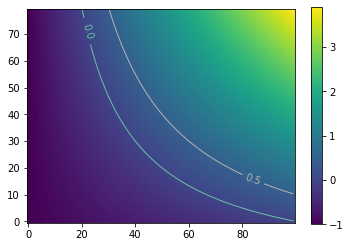

In [34]:
from numpy import arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# the function that I'm going to plot
def z_func(x,y):
    return (x*y - 1)
 
prob = arange(0.0,1.0,0.01)
odd = arange(1.0,5.0,0.05)
X,Y = meshgrid(prob, odd) # grid of point
Z = z_func(X, Y) # evaluation of the function on the grid

im = imshow(Z,origin = 'lower') # drawing the function

# adding the Contour lines with labels
cset = contour(Z,[0.0, 0.5],linewidths=1,cmap=cm.Set2)
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)

colorbar(im) # adding the colobar on the right

show()

# Performance analysis

## Calculations of expected gain for each result

In [35]:
performance_df = test_df[['FTR','IWA','IWD','IWH']]
performance_df['P(A)']= pd.DataFrame(data = results['Random Forest'][:,0], columns = ['P(A)'])
performance_df['E(A)']= performance_df['P(A)'] * performance_df['IWA'] - 1.0
performance_df['P(D)']= pd.DataFrame(data = results['Random Forest'][:,1], columns = ['P(D)'])
performance_df['E(D)']= performance_df['P(D)'] * performance_df['IWD'] - 1.0
performance_df['P(H)']= pd.DataFrame(data = results['Random Forest'][:,2], columns = ['P(H)'])
performance_df['E(H)']= performance_df['P(H)'] * performance_df['IWH'] - 1.0
performance_df

,FTR,IWA,IWD,IWH,P(A),E(A),P(D),E(D),P(H),E(H)
150,H,3.05,3.20,2.40,0.102017,-0.688847,0.124834,-0.600530,0.773148,0.855556
151,D,3.60,3.30,2.10,0.695016,1.502056,0.135198,-0.553848,0.169787,-0.643448
152,H,2.80,3.20,2.60,0.032013,-0.910365,0.061107,-0.804459,0.906881,1.357891
153,A,2.60,3.30,2.70,0.708174,0.841254,0.120654,-0.601843,0.171172,-0.537836
154,H,2.85,3.10,2.60,0.744800,1.122680,0.089703,-0.721922,0.165497,-0.569707
...,...,...,...,...,...,...,...,...,...,...
199,A,2.90,3.40,2.40,0.090730,-0.736882,0.153352,-0.478604,0.755918,0.814203
200,D,4.75,4.30,1.65,0.878980,3.175155,0.069020,-0.703214,0.052000,-0.914200
202,A,1.80,3.95,4.15,0.922846,0.661123,0.064077,-0.746896,0.013077,-0.945731
203,H,6.10,4.70,1.48,0.033013,-0.798624,0.041107,-0.806799,0.925881,0.370304


## Selection of results to bet on and their actual performances

In [51]:
#Floor and cap on expected gain to consider
floor = 1.0
cap = 15.0

### Draws performance

In [52]:
#Selection of the draws
draw_floor = performance_df['E(D)'] > floor
draw_cap = performance_df['E(D)'] < cap
selected_draw = performance_df[draw_floor & draw_cap]

#Computation of actual gains on draws
selected_draw['Gain'] = 0.0
is_Draw = selected_draw['FTR'] == 'D'
not_Draw = selected_draw['FTR'] != 'D'
selected_draw.loc[not_Draw, 'Gain'] = -1.0
selected_draw.loc[is_Draw, 'Gain'] = selected_draw.loc[is_Draw,'IWD'] - 1.0
selected_draw['Gain'].sum()

-44.7

### Aways performance

In [53]:
#Selection of the aways
away_floor = performance_df['E(A)'] > floor
away_cap = performance_df['E(A)'] < cap
selected_away = performance_df[away_floor & away_cap]

#Computation of actual gains on aways
selected_away['Gain'] = 0.0
is_Away = selected_away['FTR'] == 'A'
not_Away = selected_away['FTR'] != 'A'
selected_away.loc[not_Away, 'Gain'] = -1.0
selected_away.loc[is_Away, 'Gain'] = selected_away.loc[is_Away,'IWA'] - 1.0
selected_away['Gain'].sum()

-15.20000000000001

### Homes performance

In [54]:
#Selection of the homes
home_floor = performance_df['E(H)'] > floor
home_cap = performance_df['E(H)'] < cap
selected_home = performance_df[home_floor & home_cap]

#Computation of actual gains on aways
selected_home['Gain'] = 0.0
is_Home = selected_home['FTR'] == 'H'
not_Home = selected_home['FTR'] != 'H'
selected_home.loc[not_Home, 'Gain'] = -1.0
selected_home.loc[is_Home, 'Gain'] = selected_home.loc[is_Home,'IWH'] - 1.0
selected_home['Gain'].sum()

10.25

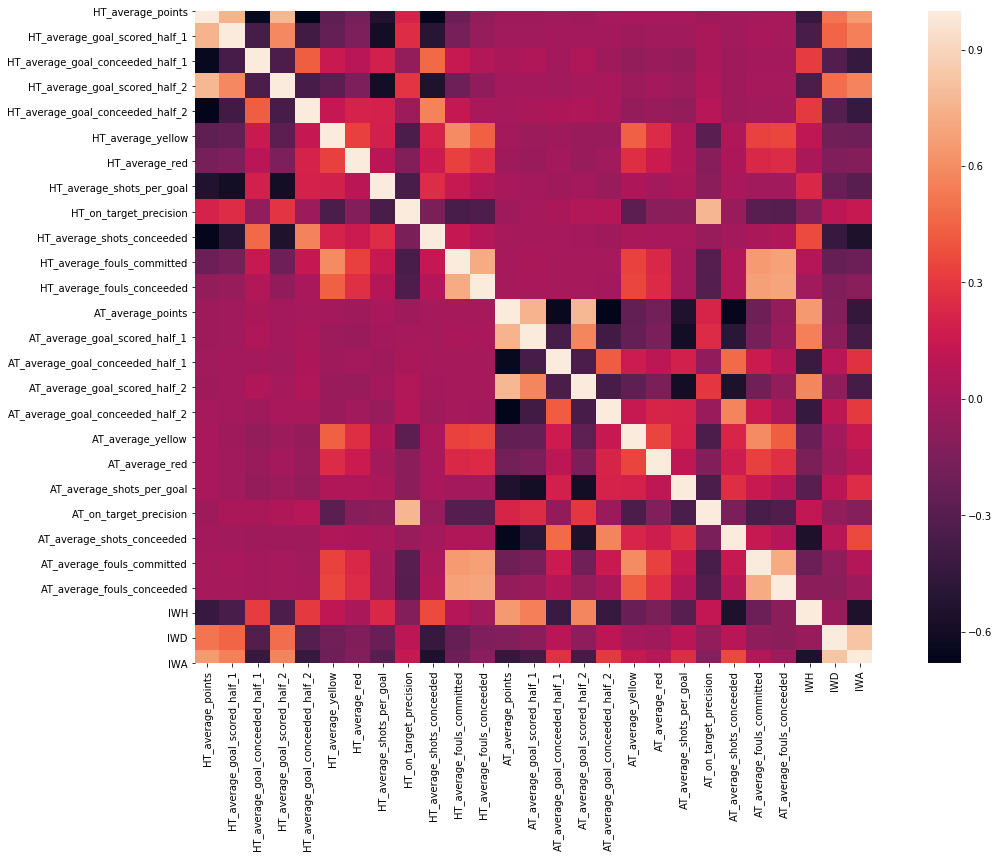

In [55]:
import matplotlib.pyplot as plt
corr_mat = train_df.corr()
fig, ax = plt.subplots(figsize=(20, 12)) 
sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax)